# HW1 - Classifiers

In [1]:
# import libraries
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

## 1. Digit Recognizer

In [2]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier

#### (a)

In [3]:
# read training and testing data
training_data=pd.read_csv("Digit_Recognition_Data/train.csv")
testing_data=pd.read_csv("Digit_Recognition_Data/test.csv")

In [4]:
labels=training_data['label'].values #extract data labels
data = training_data.drop(['label'],axis=1).values # extract data values
data_shaped = data.reshape(-1,28,28) # shape data for display

#### (b)

In [5]:
# function to display the MNIST digit indicated by the label parameter
def findDigit(label, data):
    digitIndex = list(labels).index(label)
    return data[digitIndex,:,:], digitIndex

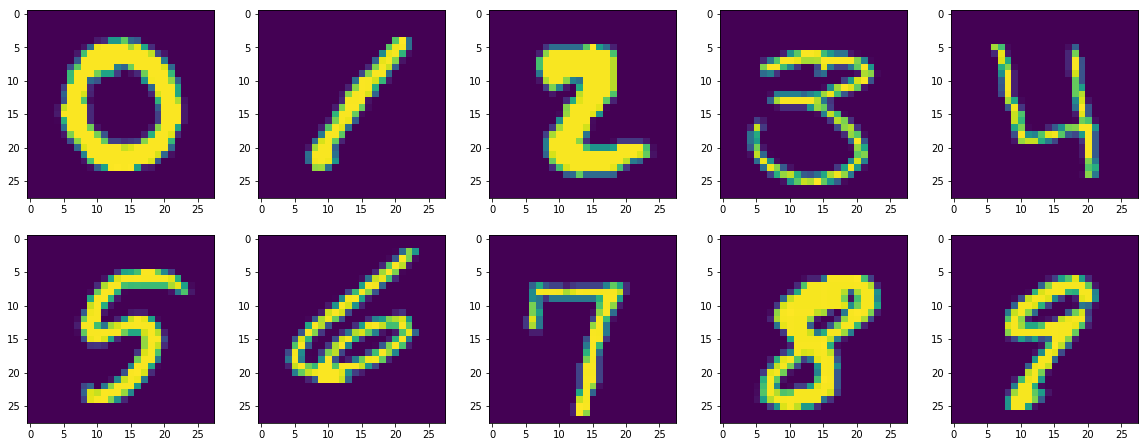

In [6]:
# plot one of each digit
plt.figure(figsize=(20,20))
for i in range(10):
    plt.subplot(5,5,i+1)
    digit, indx = findDigit(i, data_shaped)
    imshow(digit)

#### (c)

In [7]:
# function to calculate the prior probability of the class indicated by the label parameter
def calculatePrior(label):
    return np.count_nonzero(labels == label)/(42000)

Prior probability for  0 :  0.09838095238095237
Prior probability for  1 :  0.11152380952380953
Prior probability for  2 :  0.09945238095238096
Prior probability for  3 :  0.1035952380952381
Prior probability for  4 :  0.09695238095238096
Prior probability for  5 :  0.09035714285714286
Prior probability for  6 :  0.0985
Prior probability for  7 :  0.10478571428571429
Prior probability for  8 :  0.09673809523809523
Prior probability for  9 :  0.09971428571428571


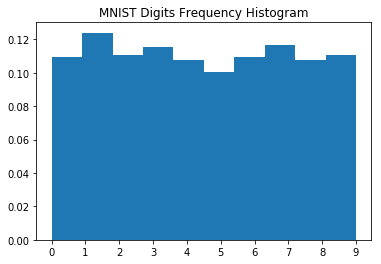

In [8]:
for i in range(10):
    print ("Prior probability for ", i, ": ", calculatePrior(i))

# plots a histogram of the labels, density = True is for normalization
plt.hist(labels, bins = 10, density = True)
plt.xticks(np.arange(10), ['0','1','2', '3', '4', '5', '6', '7', '8', '9'])
plt.title('MNIST Digits Frequency Histogram')
plt.show()

# changed this because I think they wanted a normalized historgram, not just a plot of counts
#plt.bar(x, height= [counts(0), counts(1), counts(2), counts(3), counts(4), counts(5), counts(6), counts(7), counts(8), counts(9)]) 

#### (d)

In [9]:
def euclideanDist(img1, img2):
    return np.linalg.norm(img2-img1)

In [10]:
# find one of each digit
listofDigits = [findDigit(i, data_shaped) for i in range(10)]

# separate list of digits and their indices
digits = []
dig_indxs = []
for digitTuple in listofDigits:
    digits.append(digitTuple[0])
    dig_indxs.append(digitTuple[1])

In [11]:
# find nearest neighbor to each digit
# create a list of nearest neighbors to each example digit (example digits are the same ones printed before)

nearest_neighbors = []

for i, digit in enumerate(digits):
    indx = dig_indxs[i]
    
    #distances = np.linalg.norm(data - digit)
    for j, img in enumerate(data_shaped):
        # skip the image that we are finding the nearest neighbor for
        if j == indx:
            continue
        # calculate distance
        dist = euclideanDist(np.array(digit), np.array(img))
        # update best distance
        if j == 0:
            best_dist = dist
            nearest_n = img
            best_indx = j
        else:
            if dist < best_dist:
                best_dist = dist
                nearest_n = img
                best_indx = j
    nearest_neighbors.append((nearest_n, best_indx))

The nearest neighbor for the image selected for 0 is at index 12950
The nearest neighbor for the image selected for 1 is at index 29704
The nearest neighbor for the image selected for 2 is at index 9536
* The nearest neighbor for the image selected for 3 is at index 8981
The nearest neighbor for the image selected for 4 is at index 14787
The nearest neighbor for the image selected for 5 is at index 30073
The nearest neighbor for the image selected for 6 is at index 16240
The nearest neighbor for the image selected for 7 is at index 15275
The nearest neighbor for the image selected for 8 is at index 32586
The nearest neighbor for the image selected for 9 is at index 35742


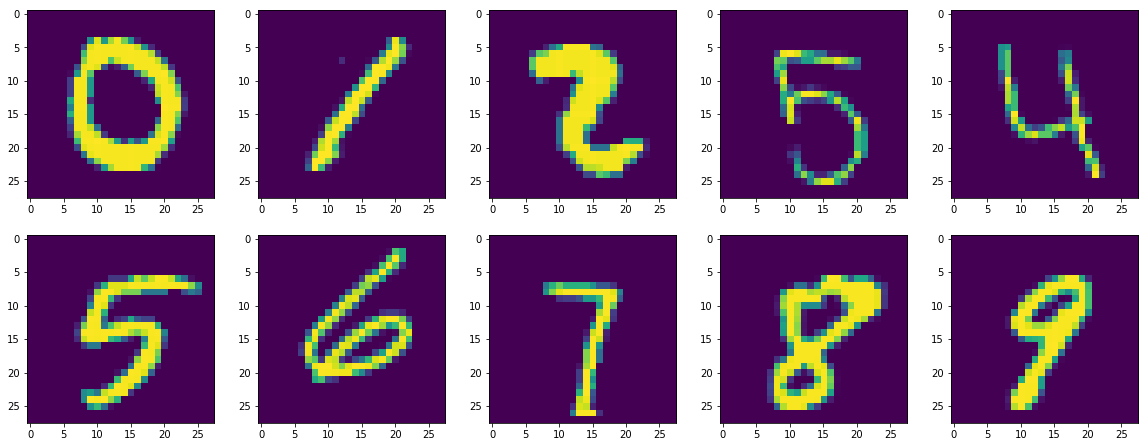

In [12]:
plt.figure(figsize=(20,20))
for i, neighbor in enumerate(nearest_neighbors):
    neighbor, indx = neighbor
    if i != labels[indx]:
        print('*', end = ' ')
    print('The nearest neighbor for the image selected for', i, 'is at index', indx)
    plt.subplot(5,5,i+1)
    imshow(neighbor)

#### (e)

In [13]:
zerosIndexes = []
onesIndexes = []
for i, label in enumerate(labels):
    if label == 0:
        zerosIndexes.append(i)
    elif label == 1:
        onesIndexes.append(i)

In [14]:
distZeros = []
for indx, i in enumerate(zerosIndexes): 
    for j in zerosIndexes[indx+1:]: 
        distZeros.append(euclideanDist(data[i], data[j]))

In [15]:
distOnes = []
for indx,i in enumerate(onesIndexes): 
    for j in onesIndexes[indx+1:]: 
        distOnes.append(euclideanDist(data[i], data[j]))

In [16]:
distImposters = []
for indx,i in enumerate(zerosIndexes): 
    for j in onesIndexes[indx+1:]: 
        distImposters.append(euclideanDist(data[i], data[j]))

for indx,i in enumerate(onesIndexes): 
    for j in zerosIndexes[indx+1:]: 
        distImposters.append(euclideanDist(data[i], data[j]))

In [17]:
distGenuine = distZeros + distOnes

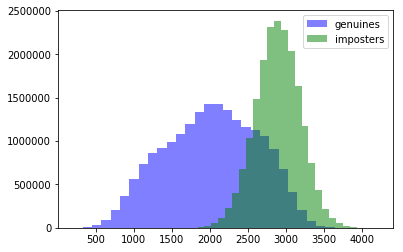

In [18]:
plt.hist(distGenuine, color = 'b', label = 'genuines', bins = 32, alpha = 0.5)
plt.hist(distImposters, color = 'g', label = 'imposters', bins = 32, alpha = 0.5)
plt.legend()

In [19]:
max(distGenuine + distImposters)

4202.085553626913

#### (f)

In [20]:
ROCPointsX = []
ROCPointsY = []
distTotal = distGenuine + distImposters

for j in range(0, math.ceil(max(distTotal)), 250):
    # FP, TN, FN, and TP are defined differently because instead of distributions of 0 and 1
        # we are given distributions of genuine and imposter
    # We are determining if we are correctly classifying into the genuine or imposter distribution
        # as opposed to determining if we are correctly classifying into 0 or 1
    
    # FPs are the stuff that is classified incorrectly as positive
    # These are the items that have a high distance compared to the threshold but are incorrectly
        # placed in the genuine distribution
    FP = sum(i > j for i in distGenuine) 
    
    # TNs are the stuff that is classified correctly as negative
    # The TNs are the items in the genuine distribution that are correctly below the distance threshold
    TN = sum(i < j for i in distGenuine) 
    
    # FNs are the stuff that is classified incorrectly as negative
    # These are the items that have a low distance compared to the threshold but are incorrectly
        # placed in the imposter distribution
    FN = sum(i < j for i in distImposters) 
    
    # TPs are the stuff that is classified correctly as positive
    # These are the items that have high distance compared to the threshold and are correctly 
        # put in the imposter distribution
    TP = sum(i > j for i in distImposters) 

    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    
    ROCPointsY.append(TPR)
    ROCPointsX.append(FPR)

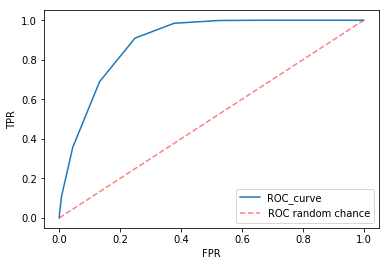

In [21]:
plt.plot(ROCPointsX, ROCPointsY, label='ROC_curve')
x = np.linspace(0,1,100)
plt.plot(x, x, color='r', linestyle='dashed', alpha = 0.5, label='ROC random chance')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.savefig('ROC_curve.png');

##### Determine EER

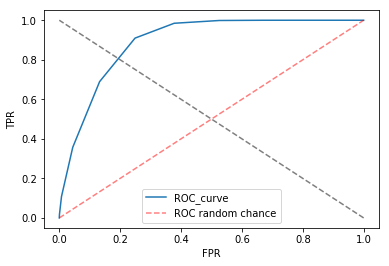

In [48]:
plt.plot(ROCPointsX, ROCPointsY, label='ROC_curve')
EER_find = -np.array(ROCPointsX)+1
plt.plot(ROCPointsX, EER_find, color='k', linestyle='dashed', alpha = 0.5)
plt.plot(x, x, color='r', linestyle='dashed', alpha = 0.5, label='ROC random chance')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()

In [50]:
print(ROCPointsX)
print(np.array(ROCPointsY)-EER_find)
print(ROCPointsX[10])
print(ROCPointsX[11])

[1.0, 0.9999998974476357, 0.9993574068855299, 0.9896705151323456, 0.9518106415619834, 0.8758960000065633, 0.7791968918426252, 0.6656127871332042, 0.525614020838336, 0.3775167250104219, 0.2488927548853257, 0.1324480705593083, 0.044194584711872195, 0.0072192762346381684, 0.0005336312274410437, 2.63046814333867e-05, 4.1020945705086476e-07]
[ 1.          0.9999999   0.99935741  0.98967052  0.95181064  0.875896
  0.7791957   0.66554095  0.52436504  0.36224408  0.15849858 -0.1781554
 -0.59863742 -0.88471627 -0.98210129 -0.99835495 -0.99992579]
0.2488927548853257
0.1324480705593083


For the ROC curve We see that the curves intersect between points at index 10 and 11. This is between FPR = 0.24889 and FPR = 0.13245. Thus, the EER for the ROC Curve is between these values.

In [51]:
print('The EER for the ROC curve is', (ROCPointsX[10]+ROCPointsX[11])/2)

The EER for the ROC curve is 0.190670412722317


The EER for the random chance curve is 0.5.

#### (g)

In [22]:
def KNNclassify(mynum, nums, labels, k):
    '''This function goes through all of the MNIST digits (nums) and checks if it is a nearest 
    neighbor to "mynum" which is a test digit that we are trying to see if we can classify after
    spliting the training data set into a test set and train set. The nums are all of the MNIST
    numbers split into the training set, the labels are all of the labels corresponding to nums.
    Finally, k is the number of neighbors.'''
    
    # find nearest neighbors
    neighbors = []
    for i, num in enumerate(nums):
        # find distance of myitem to the item we are checking
        distance = euclideanDist(mynum, num)
        
        # start with the first k items in nums
        if len(neighbors) < k: 
            neighbors.append((distance, labels[i]))
            # sort in ascending order by distance
            neighbors = sorted(neighbors)
        
        # if the distance of this item is less than max distance replace max item with this one
        elif neighbors[len(neighbors)-1][0] > distance: 
            neighbors[len(neighbors)-1] = (distance, labels[i])
            # sort in ascending order by distance
            neighbors = sorted(neighbors)
    
    # need to determine where to classify based on the labels of the neighbors   
    # the classes are just 0-9, so we can represent in an array
    class_nums = np.zeros(10)
    for neighbor in neighbors:
        class_nums[neighbor[1]] += 1
    
    # determine the best classifications based on the dict created for the neighbors
    best_guess = np.argmax(class_nums)
                
    return best_guess

In [23]:
# test my KNN classifier
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.25)

In [24]:
preds = []
for i, testnum in enumerate(x_test):
    preds.append(KNNclassify(testnum, x_train, y_train, k = 3))

In [25]:
print('The accuracy of my KNN model is', accuracy_score(y_test, preds))

The accuracy of my KNN model is 0.9661904761904762


#### (h)

##### Do crossvalidation with 3 folds on the sklearn KNN classifier with k=5.

In [26]:
X = data 
Y = labels
cv = KFold(3)

# initialize arrays for analysis
accuracy = []
predictions = []
actuals = []

# crossvalidation
for train, test in cv.split(X, Y):
    neighbors = KNeighborsClassifier(n_neighbors=5).fit(X[train], Y[train])
    predicted = neighbors.predict(X[test])
    accuracy.append(accuracy_score(Y[test], predicted))
    predictions += list(predicted)
    actuals += list(Y[test])
    
    # if we were using our KNN classifier to do the crossvalidation we would use the below code
    '''total = len(X[test])
    correct = 0
    # test all values in test data
    for i, testnum in enumerate(X[test]):
        best_guess = KNNclassify(testnum, X[train], Y[train], k = 3)
        predictions.append(best_guess)
        if best_guess == Y[test][i]: # check if the best_guess is the same as the label
            correct += 1
    # find the accuracy for this iteration
    accuracy.append((correct/total)*100)
    actuals += list(Y[test])'''

print('The average accuracy of a 3NN classifier after K-fold crossvalidation is ', np.mean(accuracy))

The average accuracy of a 3NN classifier after K-fold crossvalidation is  0.9642142857142857


The above should say "the average accuracy of a 5NN classifier"

##### Do crossvalidation with 3-folds on our KNN classifier implementation with  k=3

In [29]:
# try running our KNN classifier with crossval
X = data 
Y = labels
cv = KFold(3)

# initialize arrays for analysis
my_accuracy = []
my_predictions = []
my_actuals = []

# crossvalidation
for train, test in cv.split(X, Y):
    total = len(X[test])
    correct = 0
    # test all values in test data
    for i, testnum in enumerate(X[test]):
        best_guess = KNNclassify(testnum, X[train], Y[train], k = 3)
        my_predictions.append(best_guess)
        if best_guess == Y[test][i]: # check if the best_guess is the same as the label
            correct += 1
    # find the accuracy for this iteration
    my_accuracy.append((correct/total)*100)
    my_actuals += list(Y[test])

print('The average accuracy of a 3NN classifier after K-fold crossvalidation is ', np.mean(my_accuracy))

The average accuracy of a 3NN classifier after K-fold crossvalidation is  96.54285714285713


#### (i)

##### Confusion matrix for sklearn KNN with k=5

[[4104    1    4    0    0    7   12    2    0    2]
 [   0 4660    9    2    1    0    2    7    1    2]
 [  34   59 3966   13    3    5    3   83    8    3]
 [   5   13   28 4193    0   43    1   24   24   20]
 [   2   50    0    0 3905    0   14    7    2   92]
 [  11    9    2   73    3 3619   48    3    4   23]
 [  26    7    1    0    4   17 4081    0    1    0]
 [   2   61   11    3   13    0    0 4265    0   46]
 [  19   50   20   77   22   79   20   13 3720   43]
 [  16   13    3   33   47   11    1   69   11 3984]]


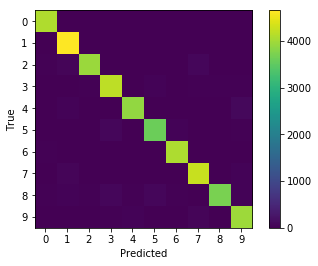

In [27]:
# need to use predictions and actuals to make a confusion matrix for library KNN
confusion_m = confusion_matrix(actuals, predictions)
print(confusion_m)

# plot the confusion_matrix in a pretty way
fig, ax = plt.subplots()
imshow(confusion_m)
plt.colorbar()
classes = [0,1,2,3,4,5,6,7,8,9]
ax.set(xticks=classes,yticks=classes,xticklabels=classes,yticklabels=classes,ylabel='True',xlabel='Predicted');

##### Confusion matrix for our KNN implementation with k=3

[[4110    0    4    0    0    5   10    0    2    1]
 [   0 4658    8    1    2    1    4    7    1    2]
 [  31   48 3988   13    5    3    4   74    7    4]
 [   6   12   34 4202    0   39    2   21   18   17]
 [   3   45    1    0 3899    0   15    4    1  104]
 [  15    4    2   75    4 3618   43    2    5   27]
 [  26    7    0    0    5   17 4080    0    2    0]
 [   2   54   10    3   12    0    0 4268    0   52]
 [  24   50   25   68   19   76   17   11 3730   43]
 [  17   11    6   34   44   13    2   59    7 3995]]


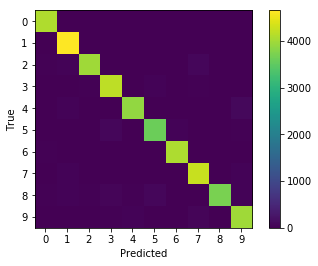

In [30]:
# need to use predictions and actuals to make a confusion matrix
confusion_m = confusion_matrix(my_actuals, my_predictions)
print(confusion_m)

# plot the confusion_matrix in a pretty way
fig, ax = plt.subplots()
imshow(confusion_m)
plt.colorbar()
classes = [0,1,2,3,4,5,6,7,8,9]
ax.set(xticks=classes,yticks=classes,xticklabels=classes,yticklabels=classes,ylabel='True',xlabel='Predicted');

#### (j)

In [31]:
all_predictions = []
for i, testnum in enumerate(testing_data.values):
    all_predictions.append(KNNclassify(testnum, data, labels, k = 3))

AttributeError: module 'pandas' has no attribute 'Dataframe'

In [33]:
all_pred_df = pd.DataFrame(all_predictions)
all_pred_df.to_csv('MNIST_submission_Simi_Eva.csv')

## 2. The Titanic Disaster

#### (a)

In [50]:
from sklearn.linear_model import LogisticRegression
import seaborn as sns

In [46]:
# read training and testing data
training_data_t=pd.read_csv("Titanic_Data/train_titanic.csv")
testing_data_t=pd.read_csv("Titanic_Data/test_titanic.csv")
labels_t=training_data_t['Survived'].values #extract data labels

#### (b)

In [47]:
# check for missing data to identify irrelevant columns
training_data_t.info() # check missing data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [48]:
count = 0
for i in training_data_t['Cabin'].values:
    if i != i:
        count+=1
percent_nan = count/(len(training_data_t['Cabin'].values))
print(percent_nan*100, '% of people have NaN for their cabin')

count = 0
for i in training_data_t['Age'].values:
    if i != i:
        count+=1
percent_nan = count/(len(training_data_t['Age'].values))
print(percent_nan*100, '% of people have NaN for their age')

77.10437710437711 % of people have NaN for their cabin
19.865319865319865 % of people have NaN for their age


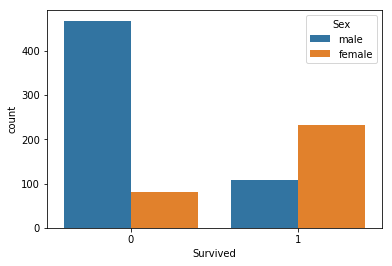

In [51]:
sns.countplot(data=training_data_t, x='Survived', hue='Sex',) # check people who survived according to sex

C:\Users\simir\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


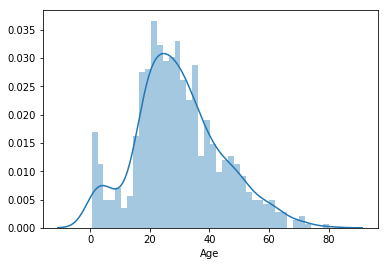

In [52]:
sns.distplot(training_data_t['Age'].dropna(), bins=40) # check people who survived according to age

We can ignore PassengerId and Name for the analysis because these are just identifying factors for the person. We will only use PassengerId after the analysis to label the survivers. Can also ignore Cabin because 77% of values in cabin are NaN. Since the tickets all have different numbers, and the passengers are grouped according to Pclass, not Ticket, we can drop the Tciket column.

From the above analysis we can see that the number of males that survived almost doubles the number of females who survived, therefore this feature is significant in our analysis. We can also see that most of the people who survived were young adults.

In [53]:
# convert sex and embarked variables in numerical data
sexDummies = pd.get_dummies(training_data_t['Sex'], drop_first = True)
embarkedDummies = pd.get_dummies(training_data_t['Embarked'], drop_first = True)

# extract passengerIds for later use
passengerIds = training_data_t['PassengerId']

# remove uneeded data and categorical data
training_data_t_clean = training_data_t.drop(['Sex', 'Name', 'Cabin', 'Ticket', 'Embarked', 'PassengerId'],axis=1) #change to not drop embarked

# add back the categorical data that was made numeric
training_data_t_clean = pd.concat([training_data_t_clean,sexDummies, embarkedDummies],axis=1)

# for people with age that is NaN value, replace their age with the mean age of the dataset
training_data_t_clean['Age'].fillna((training_data_t_clean['Age'].mean()), inplace=True)

# view what we have
training_data_t_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Age         891 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
male        891 non-null uint8
Q           891 non-null uint8
S           891 non-null uint8
dtypes: float64(2), int64(4), uint8(3)
memory usage: 44.5 KB


In [54]:
# split data into test and train set for testing
x_train, x_test, y_train, y_test = train_test_split(training_data_t_clean.drop('Survived', axis=1), 
           training_data_t_clean['Survived'], test_size=0.25)

In [55]:
# perform logistic regression
lr = LogisticRegression()
lr.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [56]:
Ps = lr.predict(x_test) # store predictions

The accuracy of our model is 84.75336322869956
[[132  13]
 [ 21  57]]


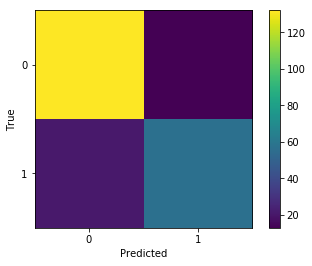

In [57]:
# understand accuracy
conf_matrix = confusion_matrix(y_test, Ps)

print('The accuracy of our model is',((accuracy_score(y_test, Ps))*100))

print(conf_matrix)

# plot the confusion_matrix
fig, ax = plt.subplots()
imshow(conf_matrix)
plt.colorbar()
classes = [0,1]
ax.set(xticks=classes,yticks=classes,xticklabels=classes,yticklabels=classes,ylabel='True',xlabel='Predicted');

#### (c)

##### Clean Test Data

In [58]:
# check missing data
testing_data_t.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [59]:
# convert sex and embarked variables in numerical data
sexDummiestest = pd.get_dummies(testing_data_t['Sex'], drop_first = True)
embarkedDummiestest = pd.get_dummies(testing_data_t['Embarked'], drop_first = True)

# extract passengerIds for later use
passengerIdstest = testing_data_t['PassengerId']

# remove uneeded data and categorical data
testing_data_t_clean = testing_data_t.drop(['Sex', 'Name', 'Cabin', 'Ticket', 'Embarked', 'PassengerId'],axis=1) #change to not drop embarked

# add back the categorical data that was made numeric
testing_data_t_clean = pd.concat([testing_data_t_clean, sexDummiestest, embarkedDummiestest],axis=1)

# for people with age that is NaN value, replace their age with the mean age of the dataset
testing_data_t_clean['Age'].fillna((testing_data_t_clean['Age'].mean()), inplace=True)

# for people with fare that is NaN value, replace their fare with the mean age of the dataset
testing_data_t_clean['Fare'].fillna((testing_data_t_clean['Fare'].mean()), inplace=True)

# view what we have
testing_data_t_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
Pclass    418 non-null int64
Age       418 non-null float64
SibSp     418 non-null int64
Parch     418 non-null int64
Fare      418 non-null float64
male      418 non-null uint8
Q         418 non-null uint8
S         418 non-null uint8
dtypes: float64(2), int64(3), uint8(3)
memory usage: 17.6 KB


In [62]:
# still need to run
full_lr = LogisticRegression().fit(training_data_t_clean.drop('Survived', axis=1), 
                                   training_data_t_clean['Survived'])
preds = full_lr.predict(testing_data_t_clean)

In [63]:
all_pred_df = pd.DataFrame(preds)
all_pred_df.to_csv('Titanic_submission_Simi_Eva.csv')